# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p_z = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$:
$$q_{\phi}(\theta \mid x) = p_z(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right| = p(T_{\phi}(z; x))$$
- It is trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_z(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$
- Once it's trained, we can sample from it using samples from the base distribution:
$$z_i\sim p_z \quad \rightarrow \quad \theta_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$$

**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N_2$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N_2}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train** classifier to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - features $[Z_i, x_i]$
    - labels: $0$ if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $1$ if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We predict the probability of belonging to class $0$ (normal distribution): $\hat{p}(Y=0\mid z,x_0)$ for several $z \sim \mathcal{N}(0,\mathbf{1}_m)$ (as we do not have access to more than one sample from $p(T^{-1}_{\phi}(\theta, x)\mid x=x_0)$). 
    
    - Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a dirac around $0.5$ (will be larger if not enough training samples, as unlikely datapoints could be considered out-of-distribution). 
    - Deviances from the dirac could inform us about the nature of the distributional inconsistencies (bias, dispersion...). 

    *Alternative: We predict the class for several $z \sim \mathcal{N}(0,\mathbf{1}_m)$ and compute the accuracy. Should be 0.5. This method is less robust, as it doesn't take into account the confidence of the predicted class. We need to repeat this for several classifiers to account for the model uncertainty.*

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- how to interpret the pp-plots of the predicted probabilities: what deviances from dirac indicate bias/dispersion? 

## Numerical illustration

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

In [2]:
from data.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0,0], sigma=[1,1], rho=0.8)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = 'saved_experiments/Gaussian1d_localPIT/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)

NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


### Density Estimation
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

In [3]:
from nde.flows import construct_maf
from nde.train import train
from data.feature_transforms import first_dim_only, identity

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=True, num_layers=5
)

# ... trained on X=(X_1,X_2)
filename = 'saved_experiments/Gaussian1d_localPIT/maf_good.pkl'
if os.path.exists(filename):
    maf_good = torch.load(filename)
else:
    _, _ = train(
        maf_good,
        theta_train,
        context=x_train,  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=True, num_layers=5
)

# ... trained on g(X)=(X_1)
g = first_dim_only
filename = 'saved_experiments/Gaussian1d_localPIT/maf_bad.pkl'
if os.path.exists(filename):
    maf_bad = torch.load(filename)
else:
    _, _ = train(
        maf_bad,
        theta_train,
        context=g(x_train),  # g(X)=(X_1)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

torch.save(maf_good, 'saved_experiments/Gaussian1d_localPIT/maf_good.pkl')
torch.save(maf_bad, 'saved_experiments/Gaussian1d_localPIT/maf_bad.pkl')

### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [4]:
# Compute the inverse flow transformation on samples from the calibration set 
inv_flow_samples_cal_good = maf_good._transform(theta_cal, context=x_cal)[0].detach().numpy()
inv_flow_samples_cal_bad = maf_bad._transform(theta_cal, context=first_dim_only(x_cal))[0].detach().numpy()

# Generate data from the base / normal distribution 
from scipy.stats import norm
norm_samples = norm().rvs(cal_size)

#### 1. Global Consistency Check
We start by looking at the overall performance of our estimators: c2st score between the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$, directly compared to $\mathcal{N}(0,1)$. This gives us the expected performance over the $x$-space, and not for a specific location $x_0$. 

In [5]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good = c2st_scores(torch.tensor(inv_flow_samples_cal_good), torch.tensor(norm_samples[:,None]), n_folds=10)
scores_bad = c2st_scores(torch.tensor(inv_flow_samples_cal_bad), torch.tensor(norm_samples[:,None]), n_folds=10)
print('good:', np.mean(scores_good).__round__(2), '+/-', np.std(scores_good).__round__(2))
print('bad:', np.mean(scores_bad).__round__(2), '+/-', np.std(scores_bad).__round__(2))

good: 0.51 +/- 0.01
bad: 0.5 +/- 0.01


Both estimators (good and bad) show good average performance! 

#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

In [6]:
# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_test))]
).reshape(-1, 1)

#### True and estimated densities at $x_0$

/data/parietal/store/work/jlinhart/git_repos/valDiags_flows/plot.py:12: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/RangeFactories.cpp:20.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1, 1)


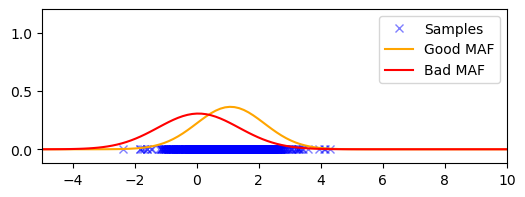

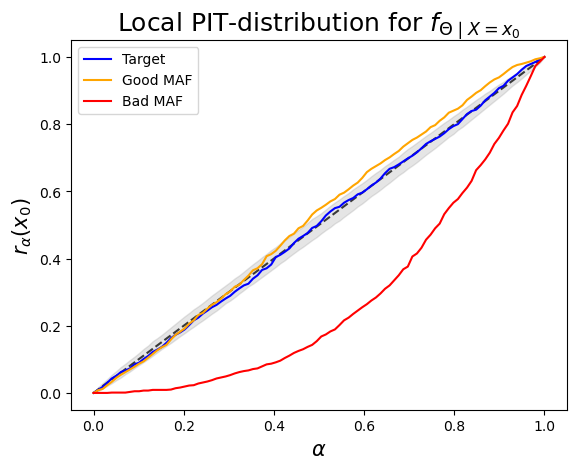

In [7]:
from plot import plot_pdf_1D
from diagnostics.pp_plots import PP_plot_1D, cde_pit_values

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)

# Plot true local PIT distribution 
# Compute PIT-values [PIT(Theta_i, X=x_0, f_true/good/bad) = F_{Q|X_i}(Theta_i)]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values(
    samples_theta_x, x_0, flow=maf_good, feature_transform=identity, local=True
)
flow_local_pit_values_bad = cde_pit_values(
    samples_theta_x, x_0, flow=maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plots: [P_{Theta|X}(Z < alpha)] on (0,1)
alphas = np.linspace(0,1,100)
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=alphas,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $f_{\Theta \mid X=x_0}$",
    confidence_int=True,
)


- bad maf: negative bias and a little overdispersed
- good maf: seems fine, just a little positive bias.

#### Local C2ST at $x_0$

##### Predict probas at $x_0$ 

In [9]:
# train classifier and predict probas for x_0
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st

n_trials = 1000
probas_good = []
probas_bad = []
probas_null = []
for t in range(n_trials): 
        # good and bad maf  
        clf_good = local_flow_c2st(inv_flow_samples_cal_good, x_cal)
        clf_bad = local_flow_c2st(inv_flow_samples_cal_bad, x_cal)
        probas_good.append(eval_local_flow_c2st(clf_good, x_0[0], dim=1, n_rounds=1000))
        probas_bad.append(eval_local_flow_c2st(clf_bad, x_0[0], dim=1, n_rounds=1000))

        # null hypothesis
        clf_null = local_flow_c2st(norm_samples, x_cal)
        probas_null.append(eval_local_flow_c2st(clf_null, x_0[0], dim=1, n_rounds=1000))

In [8]:
# Load pre-computed results 
filename_good = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_good.pkl'
filename_bad = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_bad.pkl'
filename_null = 'saved_experiments/Gaussian1d_localPIT/lc2st_results/probas_null.pkl'

if os.path.exists(filename_good):
    probas_good = torch.load(filename_good)
if os.path.exists(filename_bad):
    probas_bad = torch.load(filename_bad)

if os.path.exists(filename_bad):
    probas_null = torch.load(filename_null)
    

##### Plot histograms 

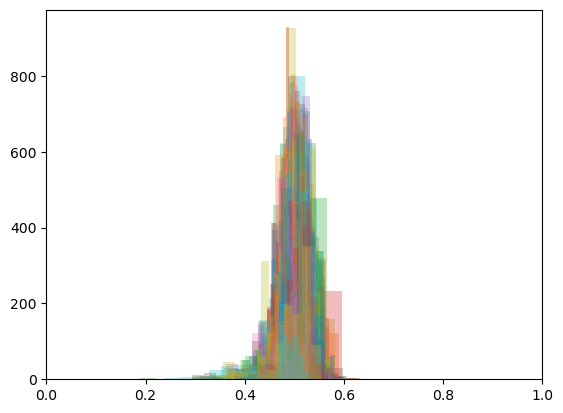

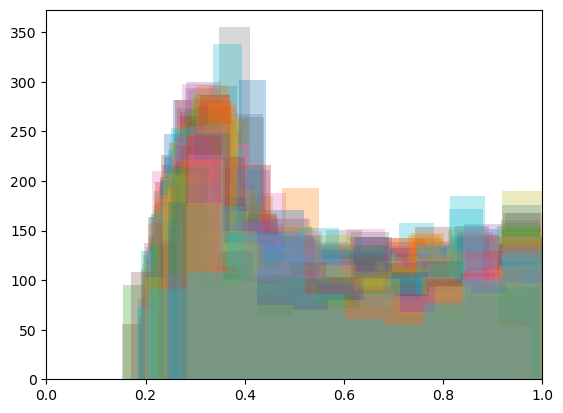

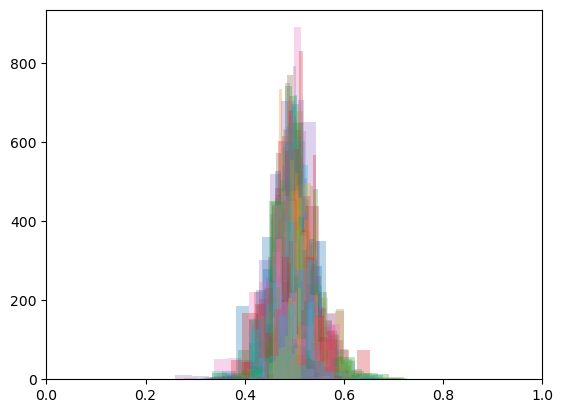

In [11]:
n_trials = 1000

for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

1. Distribution (c.d.f.) of predicted probas 

The associated test-statistic is the euclidean distance to the dirac function at $0.5$ (black dashed line).

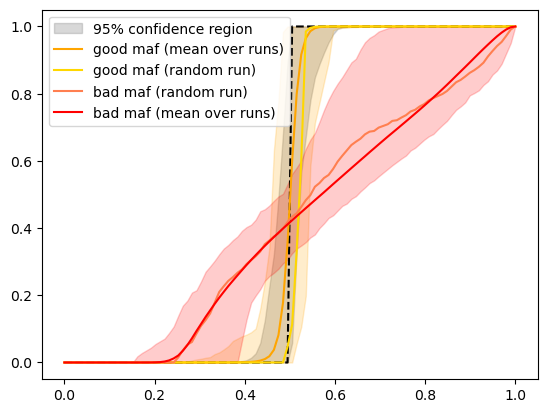

Test statistics and p-values for the chosen random run:

test stat good :  0.01399357
p-value good :  0.067

test stat bad :  0.0648756
p-value bad :  0.0


In [9]:
from diagnostics.pp_plots import PP_vals

random_run_idx = np.random.randint(0,1000)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
plt.plot(alphas, pp_vals_dirac, '--', color='black')

pp_vals_null = {}
test_stats_null = {}
for t in range(len(probas_null)):
    pp_vals_null[t] = pd.Series(PP_vals(probas_null[t], alphas))
    test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

pp_vals_good = {}
pp_vals_bad = {}
for t in range(len(probas_null)):
    pp_vals_good[t] = pd.Series(PP_vals(probas_good[t], alphas))
    pp_vals_bad[t] = pd.Series(PP_vals(probas_bad[t], alphas))

low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
plt.fill_between(alphas, low_null, up_null, color="grey", alpha=0.3, label='95% confidence region')

low_good = pd.DataFrame(pp_vals_good).min(axis=1)
up_good = pd.DataFrame(pp_vals_good).max(axis=1)
line_good = pd.DataFrame(pp_vals_good).mean(axis=1)
plt.plot(alphas, line_good, label='good maf (mean over runs)', color='orange')
plt.plot(alphas, pp_vals_good[random_run_idx], color='gold', label='good maf (random run)')
plt.fill_between(alphas, low_good, up_good, color="orange", alpha=0.2)

low_bad = pd.DataFrame(pp_vals_bad).min(axis=1)
up_bad = pd.DataFrame(pp_vals_bad).max(axis=1)
line_bad = pd.DataFrame(pp_vals_bad).mean(axis=1)
plt.plot(alphas, pp_vals_bad[random_run_idx], color='coral', label='bad maf (random run)')
plt.plot(alphas, line_bad, label='bad maf (mean over runs)', color='red')
plt.fill_between(alphas, low_bad, up_bad, color="red", alpha=0.2)
plt.legend()
plt.show()


# Test statistics and p-values for the chosen random run 
print('Test statistics and p-values for the chosen random run:')
print()
test_stat_good = ((pp_vals_good[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_good = sum(1 * (test_stat_good < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat good : ', test_stat_good)
print('p-value good : ', p_value_good)
print()

test_stat_bad = ((pp_vals_bad[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_bad = sum(1 * (test_stat_bad < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat bad : ', test_stat_bad)
print('p-value bad : ', p_value_bad)

2. Alternative: Accuracy for several classifiers

*Like c2st from sbi.utils.metrics in the non-local case (cross-val)*

In [11]:
accuracy_good = []
accuracy_bad = []
accuracy_null = []
for i in range(1000):
    accuracy_good.append(np.mean(np.array(probas_good[i])>=0.5))
    accuracy_bad.append(np.mean(np.array(probas_bad[i])>=0.5))
    accuracy_null.append(np.mean(np.array(probas_null[i])>=0.5))

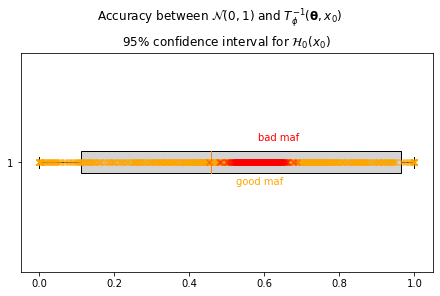

null hyp: 0.48677099999999995 0.24266359545469526
good maf: 0.5250370000000001 0.26510050477318975
bad maf: 0.582778 0.03015133025257757


In [19]:
import matplotlib.cbook as cbook

data = accuracy_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(accuracy_good), 0.9, 'good maf', color='orange')
plt.scatter(np.mean(accuracy_good), 1, color='orange', zorder=10)
for a in accuracy_good:
    plt.scatter(a, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(accuracy_bad), 1.1, 'bad maf', color='red')
plt.scatter(np.mean(accuracy_bad), 1, color='red')
for a in accuracy_bad:
    plt.scatter(a, 1, marker='x', color='red', zorder=11, alpha=0.3)


# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x_0)$')
plt.suptitle(r'Accuracy between $\mathcal{N}(0,1)$ and $T_{\phi}^{-1}(\mathbf{\theta}, x_0)$')
plt.show()
print('null hyp:', np.mean(accuracy_null), np.std(accuracy_null))
print('good maf:', np.mean(accuracy_good), np.std(accuracy_good))
print('bad maf:', np.mean(accuracy_bad), np.std(accuracy_bad))

It seems that this metric would focus on the std of the predicted accuracy: 
- null hyp / good maf: not confident at all (large std) with a mean accuracy around 0.5 
- bad maf: very confident (small std) with a mean not equal to 0.5

### Choice of classification model cal-set size

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torch.distributions as D
import time

#### Accuracy - Shift experiment - Model choice
We compute the global cross-val c2st accuracy score between two 1D gaussians: 
- Reference: $\quad \mathcal{N}(0,1)$
- Gaussian with shifted mean or std: $\quad \mathcal{N}(m,1), m \in [0,10] \quad$ or $\quad \mathcal{N}(0,s), s \in [1,20]$

The classifiers are trained on samples of the joint: $[z_i, x_i]$ where the $z_i$ correspond to samples from the reference or the other gaussian distribution with lables 0 or 1.

We can also look at the total cv time.

##### Experimental SET-UP

In [ ]:
def eval_clf_local_c2st(x_samples, ref_samples, shifted_samples, shifts, clf_class, clf_kwargs, nfolds=10):
    ref_joint_samples = torch.cat([ref_samples,x_samples], dim=1)
    shift_list = []
    scores = []
    times = []
    for s_samples,s in zip(shifted_samples, shifts):
        s_joint_samples = torch.cat([s_samples, x_samples], axis=1)
        start = time.time()
        cross_val_scores = c2st_scores(ref_joint_samples, s_joint_samples, n_folds=nfolds, clf_class=clf_class, clf_kwargs=clf_kwargs)
        total_cv_time = time.time() - start
        for t in range(nfolds):
            shift_list.append(s)
            scores.append(cross_val_scores[t])
            times.append(total_cv_time)
    return shift_list, scores, times

In [107]:
N_list = [1000, 2000, 5000]
mean_shifts = [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 5, 10]
scale_shifts = np.linspace(1, 20, 10)

# Datasets 
x_samples = {}
ref_samples = {}
for n in N_list:
    x_samples[n] = data_gen.sample_x(n)
    ref_samples[n] = D.MultivariateNormal(loc=torch.zeros(1), covariance_matrix=torch.eye(1)).rsample((n,))

mean_shifted_samples = {}
scale_shifted_samples = {}
for n in N_list:
    mean_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)
        ).rsample((n,))
        for m in mean_shifts
    ]
    scale_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.zeros(1), covariance_matrix=torch.eye(1) * s
        ).rsample((n,))
        for s in scale_shifts
    ]

# Models 
ndim = x_samples[1000].shape[-1] + ref_samples[1000].shape[-1]
clf_classes = {"mlp_base": MLPClassifier, "mlp_sbi": MLPClassifier, "rf": RandomForestClassifier, "logreg": LogisticRegression}
clf_kwargs_dict = {
    "mlp_base": {},
    "mlp_sbi": {
        "activation": "relu",
        "hidden_layer_sizes": (10 * ndim, 10 * ndim),
        "max_iter": 1000,
        "solver": "adam",
        "early_stopping": True,
        "n_iter_no_change": 50,
    },
    "rf": {},
    "logreg": {}
}

clf_names = ["logreg", "mlp_base", "mlp_sbi","rf"]

##### Mean shifts

In [108]:
filename = 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl'
if os.path.exists(filename):
    dfs_mean = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl')
else:
    dfs_mean = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_clf_local_c2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=mean_shifted_samples[n],
                shifts=mean_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'mean_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_mean[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_mean, 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_mean.pkl')


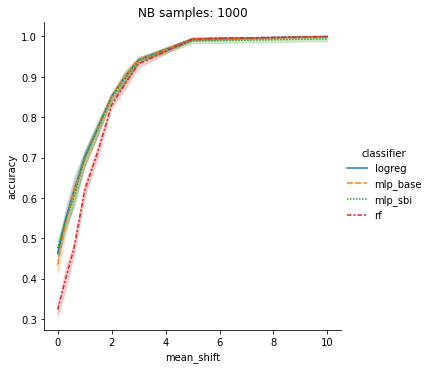

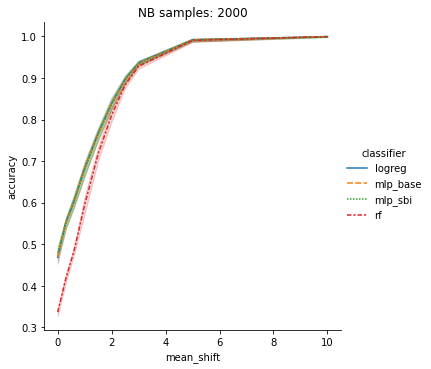

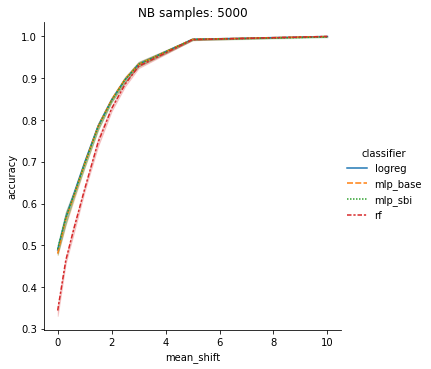

In [110]:
import seaborn as sns
for n in N_list:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale Shifts

In [109]:
filename = 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl'
if os.path.exists(filename):
    dfs_scale = torch.load('saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl')
else:
    dfs_scale = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_clf_local_c2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=scale_shifted_samples[n],
                shifts=scale_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'scale_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_scale[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_scale, 'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/dfs_scale.pkl')

/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/envs/nflows/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


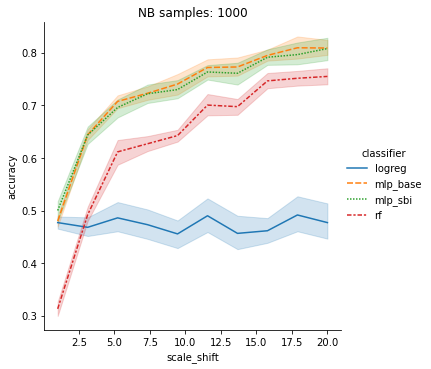

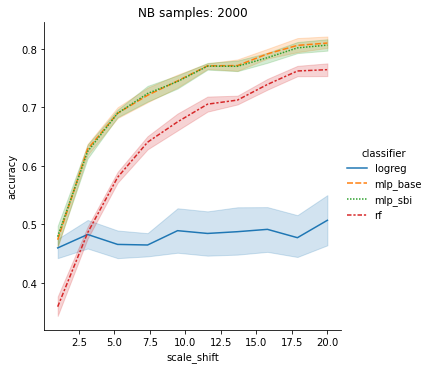

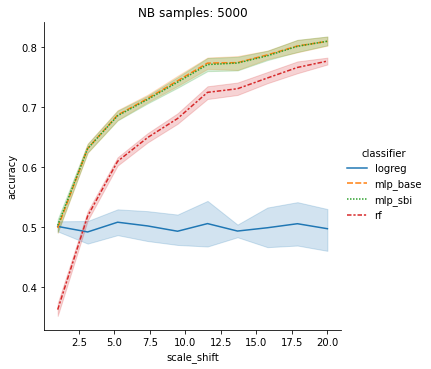

In [112]:
for n in N_list:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

We coose the MLP classifier (for this example the mlp_base seems to be enough, we still chose the default mlp from `sbi.utils.metrics`)

#### Precision under the null hypothesis - cal set size 

For different cal set sizes we compute the cross-val test statistics (distance to dirac c.d.f) and stds of the predicted distribution (output of `eval_local_flow_c2st`) under the null hypothesis.

We relax the problem from a dirac to a gaussian distribution with std of 0.05 or 0.1 (smooth dirac):
- we compute the theoretical test-statistics of those two gaussians 
- we compare the obtained test-statistics and stds of the cross-validation to these theoretical values

##### Theoretical Test-stats for chosen stds

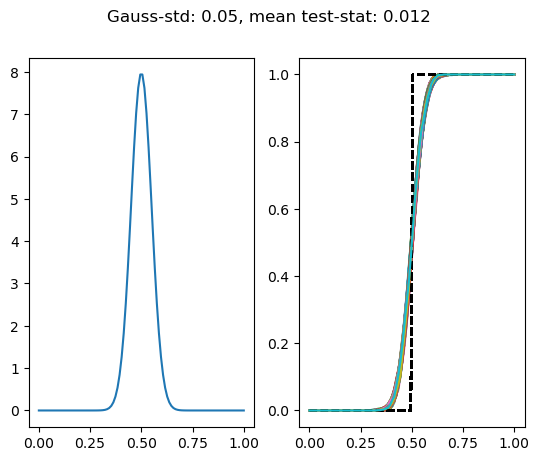

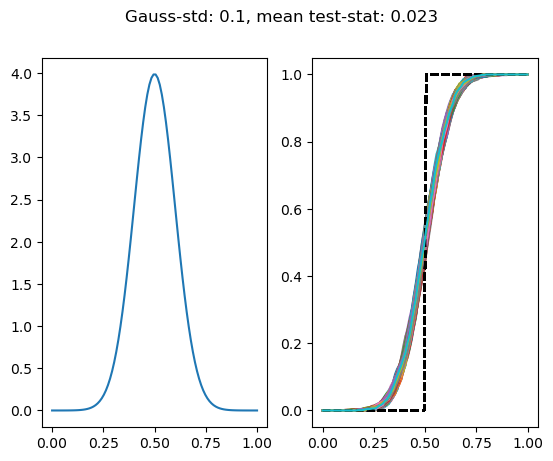

In [ ]:
def smooth_dirac(eps=0.1):
    return norm(loc=0.5,scale=eps)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
for e in [0.05, 0.1]:
    fig, axs = plt.subplots(1,2)
    axs[0].plot(alphas,[smooth_dirac(eps=e).pdf(x) for x in alphas])

    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    test_stats = []
    for t in range(1000):
        samples = smooth_dirac(eps=e).rvs(1000)
        pp_vals = pd.Series(PP_vals(samples, alphas))
        test_stats.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
        axs[1].plot(alphas, pp_vals_dirac, '--', color='black')
        axs[1].plot(alphas, pp_vals)
    plt.suptitle(f'Gauss-std: {e}, mean test-stat: {np.round(np.mean(test_stats),3)}')
    plt.show()

##### Experimental SETUP

In [25]:
from diagnostics.localPIT_regression import local_flow_c2st, eval_local_flow_c2st
from sklearn.model_selection import KFold

def eval_clf_null(x_samples, dim=1, n_list=[1000], classifiers=['mlp'], n_trials=100):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    nb_samples = []
    probas_stds = []
    test_stats = []
    times = []
    clf_method = []

    for n in n_list:
        Q = D.MultivariateNormal(loc=torch.FloatTensor([0]*dim), covariance_matrix=torch.eye(dim)).rsample((n,))
        kf = KFold(n_splits=n_trials, shuffle=True, random_state=1)
        for clf_name in classifiers:
            start = time.time()
            for t, (train_index, test_index) in enumerate(kf.split(x_samples[n])):
                x_samples_train = x_samples[n][train_index]
                x_samples_test = x_samples[n][test_index]
                Q_train = Q[train_index]
                Q_test = Q[test_index]
                clf = local_flow_c2st(Q_train, x_samples_train, classifier=clf_name)
                std_x = []
                test_stats_x = []
                for i,x_obs in enumerate(x_samples_test):
                    proba = eval_local_flow_c2st(clf, x_obs, dim=dim, n_rounds=1000)
                    pp_vals = pd.Series(PP_vals(proba, alphas))
                    test_stats_x.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
                    std_x.append(np.std(proba))
                probas_stds.append(np.mean(std_x))
                test_stats.append(np.mean(test_stats_x))
                nb_samples.append(n)
    
            total_cv_time = time.time() - start
            for t in range(n_trials):
                times.append(total_cv_time)
                clf_method.append(clf_name)
    df = pd.DataFrame({f'nb_samples': nb_samples, 'probas_std': probas_stds, 'test_stats': test_stats, 'total_cv_time':times, 'classifier':clf_method,})
    # filename = f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_null_std_cv_n_{n_list}_ntrials_{n_trials}_Tstats.pkl'
    # torch.save(df, filename)
    return df

In [22]:
N_LIST = [1000, 2000, 3000, 5000, 6000, 10000]

data_gen = ConditionalGaussian1d()
x_samples = {}
for n in N_LIST:
    x_samples[n], _ = data_gen.get_joint_data(n=n)

##### Results

In [27]:
# dfs = []
# for n in N_LIST:
#     dfs.append(eval_clf_null(x_samples, n_list=[n]))

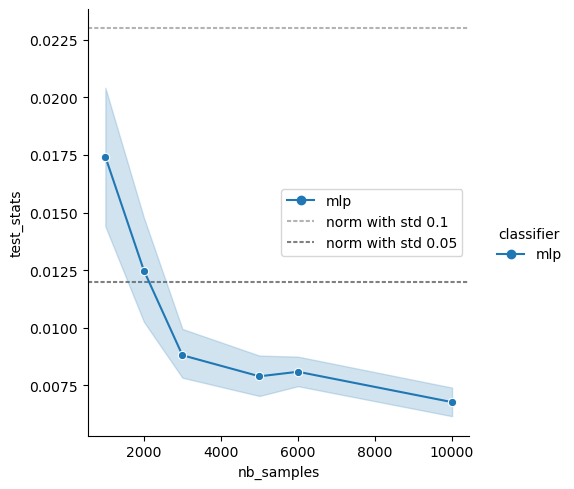

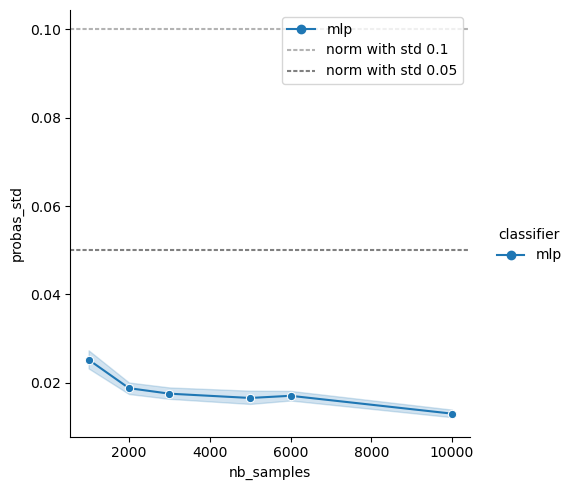

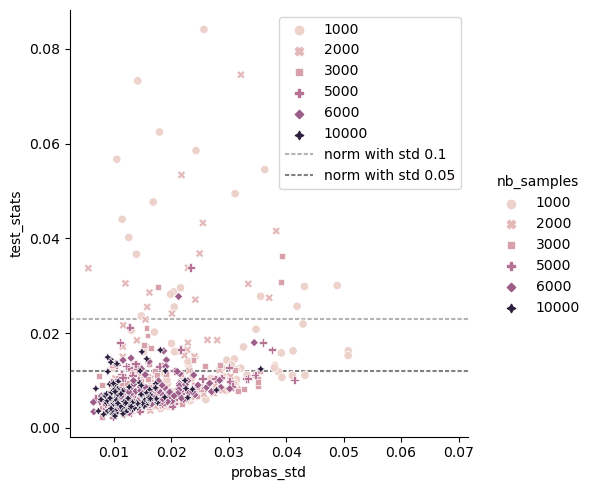

(0.05080683914882537, 0.04328133866296062)

In [34]:
import seaborn as sns

dfs = []
for n in N_LIST:
    dfs.append(torch.load(f'saved_experiments/Gaussian1d_localPIT/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats.pkl'))

df = pd.concat(dfs, ignore_index=True)

g = sns.relplot(
        data=df, x="nb_samples", y="test_stats",
        hue="classifier", style="classifier", kind="line", markers='o'
    )
g.map(plt.axhline, y=0.023, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.012, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()

g = sns.relplot(
        data=df, x="nb_samples", y="probas_std",
        hue="classifier", style="classifier", kind="line", markers='o'
    )
g.map(plt.axhline, y=0.1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.05, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()

g = sns.relplot(
        data=df, x="probas_std", y="test_stats",
        hue="nb_samples", style="nb_samples", kind="scatter", 
    )
g.map(plt.axhline, y=0.023, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
g.map(plt.axhline, y=0.012, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
plt.legend()
plt.show()
df[df['test_stats']<=0.023]['probas_std'].max(), df[df['test_stats']<=0.012]['probas_std'].max()

Results:
- plot 1: the wanted test statistics are obtained for a sample size of 2-3_000 (for 0.05 std) and always for 0.1 std
- plot 2: the predicted proba std is always below 0.1 and 0.05 (95% CI)
- plot 3: Larger sample sizes ensure small test statistics for small stds (closer to theory). There are no data points that deviate from the theory (see printed max stds below plot that are respectively smaller than 0.1 and 0.05) 

What sample size do we chose? the smallest one to obtain best accuracy for shift-experiment --> results are shown for 5000 but a sample size of 2000 could be worth a try...